
# Regularized Linear Regression and $K$-Fold Cross Validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA # Import Linear Algebra module from NumPy
from numpy.linalg import inv # Import the 'inv' function from Linear Algebra for matrix inversion

Tasks for this lab:

* Generate linearly separable data with different amount of noise;

* Calculate the Least Square Regression (LSR) solution without or with regularization (Ridge, Lasso and Elastic Net);

* Test which of the three methods achieve bettter test error.

## Data Generation for Regression (cfr Lab 1)


In [2]:
def datagen(d, points, m, M, w, sigma):
    """
    Parameters
    ----------
    d : int
        Dimension of each data sample
    points : int
        Number of points to be generated
    m : float
        Lower bound for the domain of the data points
    M : float
        Upper bound for the domain of the data points
    w : float array of dim d
        Vector of weights of the linear model
    sigma : float
        Standard deviation of the noise eps
    """
    X = np.zeros((points, d))
    for i in range(points):
        X[i,:] = np.random.uniform(m, M, d)
    eps = np.random.normal(0, sigma, points)
    y = np.dot(X, w) + eps
    return X, y

The given Python code defines a function called `datagen` that generates random data points for a linear regression model with some added noise. Here's an explanation of what the code does:

1. An empty array `X` is created with dimensions `(points, d)` to store the generated data points. Each row of this array represents a data sample, and each column represents a feature.

2. A `for` loop iterates over each data point to be generated (`points` iterations).

3. Inside the loop, a random data sample is generated and assigned to the `i`-th row of the `X` array. This random sample is generated using `np.random.uniform(m, M, d)`, which generates `n*d` random values within the range `[m, M]` for each feature of the data point.

4. An array `eps` of random noise is generated using `np.random.normal(0, sigma, points)`. This array has the same length as the number of data points and represents random noise with a normal distribution and the specified standard deviation `sigma`.

5. The target variable `y` is generated for each data point by taking the dot product of the data point `X[i]` and the weight vector `w`. Then, the corresponding noise value `eps[i]` is added to it. This simulates a linear regression model where the target variable is a linear combination of the features with some added Gaussian noise.

In [3]:
# generate multi-dimensional regression dataset
d = 100
w = np.random.normal(0, 1, d)
sigma = 0.1
points = 1000
m = -10
M = 10

X, y = datagen(d, points, m, M, w, sigma)

## Gradient Descent for (Regularized) Linear Regression

Squared error loss and its gradient for **non-regularized linear regression** (cfr Lab 3):


$$
\mathcal{L}=\frac{1}{n}\|y-Xw\|_{2}^{2},\;\;\;\;\nabla_{w} \mathcal{L} = -\frac{2}{n}X(y-Xw)
$$

In [4]:
def SquareLoss(X, y, w):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line
    """
    return LA.norm(y-X@w,2)

The function calculates the square loss as follows:

1. `X @ w`: This is the matrix-vector multiplication of the dataset `X` with the weight vector `w`. It results in a vector of predicted values, one for each data point.

2. `y - X @ w`: This computes the element-wise difference between the true values `y` and the predicted values obtained in the previous step.

3. `LA.norm(y - X @ w, 2)`: This computes the L2 norm (Euclidean norm) of the vector obtained in step 2, which is essentially the square root of the sum of squared differences between true and predicted values.

4. The computed L2 norm represents the square loss, which measures how well the linear model's predictions match the actual ground truth values. Smaller values indicate better model fit, while larger values indicate greater prediction errors.

In [5]:
def OLSGradient(X, y, w, points):
    return (-2/points)*((y-X@w)@X)


def GD(X, y, iter, gamma, points, d):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    points : int
        Number of points in our dataset
    d : int
        Dimensionality of each data point in the dataset
    """
 # Initialize arrays to store weights and losses
    W = np.zeros((d, iter)) # To store weights at each iteration
    L = np.zeros(iter) # To store losses at each iteration

    # Initialize the weight vector w with small random values
    w = np.random.normal(0, 0.1, d)

    # GD iterations
    for i in range(iter):
        # Store the current weight vector in W
        W[:,i] = w

        # Update the weight vector w using Gradient Descent
        # The update rule is based on the gradient of the loss
        w = w + (2*gamma/points)*((y-X@w)@X)

        # Calculate and store the loss at the current iteration
        L[i] = SquareLoss(X,y,w)

    # Return the history of weight vectors and loss values
    return W, L

In [6]:
# Determine the dimensionality of the dataset
d = np.shape(X)[1]

iter = 100
points = 100
gamma = 0.001

# Apply Gradient Descent (GD) to train a linear regression model
wgd, L = GD(X, y, iter, gamma, points, d)

# the last stored weights are the most updated ones
wpred = wgd[:,-1]

print('L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights: ', LA.norm(w-wpred,2))

L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights:  0.006048822428807377


Squared error loss and its gradient for **Ridge regression**:

$$
L=\|y-Xw\|_{2}^{2}+\lambda\|w\|_{2}^{2},\;\;\;\;\nabla_{w} L = -X(y-Xw)+2\lambda w
$$

- λ (lambda) is a hyperparameter that controls the amount of regularization applied to the model.

Ridge Regression performs $L2$ regularization, i.e. it minimizes the penalized sum of squares in such a way that smaller $w$ are preferred, indeed the closer the $w$ are to $0$, the smaller is the loss function.
Ridge Regression tends to shrink the coefficients, especially those that are not very informative, towards zero.


In [7]:
def RidgeSquareLoss(X, y, w, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line1995
    lam : float
        Weight of the L2 penalty term
    """
    return SquareLoss(X, y, w) + lam*LA.norm(w,2)


def RidgeGradient(w, lam):
    return 2*lam*w

In [8]:
def GDRidge(X, y, iter, gamma, points, d, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    points : int
        Number of points in our dataset
    d : int
        Dimensionality of each data point in the dataset
    lam : float
        Weight of the L2 penalty term
    """
    W = np.zeros((d, iter))  # Array to store weights at each iteration
    L = np.zeros(iter)       # Array to store loss values at each iteration
    w = np.zeros(d)          # Initialize weights with zeros

    for i in range(iter):
        W[:, i] = w  # Store the current weights in the W array
        # Update weights using gradient descent with both OLS and Ridge components
        w = w - gamma * (OLSGradient(X, y, w, points) + RidgeGradient(w, lam))
        # Calculate and store the current loss value with Ridge regularization
        L[i] = RidgeSquareLoss(X, y, w, lam)

    return W, L


In [9]:
d = np.shape(X)[1]
iter = 100
points = 100
gamma = 0.001
lam = 0.1

wgdR, L = GDRidge(X, y, iter, gamma, points, d, lam)
wpredR = wgdR[:,-1]
print('L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights: ', LA.norm(w-wpredR,2))

L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights:  0.007288313325458229


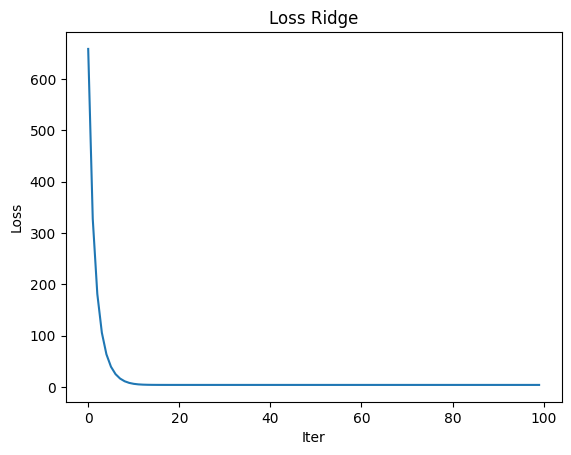

In [10]:
plt.plot(L)
plt.title('Loss Ridge')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

Squared error loss and its gradient for **Lasso (Least Absolute Shrinkage and Selection Operator) regularization**:

$$
L=\|y-Xw\|_{2}^{2}+\lambda\|w\|_{1},\;\;\;\;\nabla_{w} L = pr[-X(y-Xw)]
$$

This regularization method is useful for feature selection as it can lead to some of the feature coefficients becoming exactly zero. This means that Lasso not only helps in fitting a model to the data but also acts as an automatic feature selector, effectively ignoring some features during the modeling process.

Since we cannot compute the gradient of the penalization term (as it is not differentiable at $0$), we will use **subgradient descent**, that is an algorithm for minimizing a nondifferentialble convex function.

We define the sub-differential of the absolute value function as:

$$
\partial \|w\|_1 = \left\{\begin{matrix}
1 & w>0 \\  
-1 & w<0 \\
0 & w=0
\end{matrix}\right.
$$

Hence:

$$
\nabla_{w} L = -\frac{2}{n}\cdot-X(y-Xw))+\lambda \partial \|w\|_1
$$

This gradient includes two terms: the first term handles the squared error loss, while the second term incorporates the subdifferential of the L1 penalty term. The regularization strength $\lambda$ controls the impact of the L1 penalty on the optimization process, allowing for the shrinking of coefficients towards zero, effectively achieving feature selection.

In [11]:
def LassoSquareLoss(X, y, w, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line
    lam : float
        Weight of the L1 penalty term
    """
    return SquareLoss(X, y, w) + lam*LA.norm(w,1)

In [23]:
def L1_subgradient(z):
    """
    Compute the subgradient of the absolute value function element-wise.

    Parameters:
    ----------
    z : array-like
        Input array for which the subgradient is calculated.

    Returns:
    ----------
    g : array-like
        Subgradient of the absolute value function applied element-wise to `z`.
    """
    # Create an array g of the same shape as z, initialized with all 1s.
    g = np.ones(z.shape)

    # Check each element of z.
    for i in range(z.shape[0]):
    # If the element is negative, set the corresponding element in g to -1.
       if z[i] < 0.:
          g[i] = -1.0
    # If the element is zero, set the corresponding element in g to 0.
       elif z[i] == 0.:
         g[i] = 0.0


    # Return the resulting array g, representing the subgradient.
    return g

def LassoGradient(w, lam):
    return lam * L1_subgradient(w)

In [24]:
def GDLasso(X, y, iter, gamma, points, d, lam):
    """
    Perform Gradient Descent for Lasso (L1-regularized) Linear Regression.

    Parameters:
    ----------
    X : array-like, shape (n, d)
        Matrix containing the dataset.
    y : array-like, shape (n,)
        Vector containing the ground truth values of each data point.
    iter : int
        Number of GD iterations.
    gamma : float
        Learning rate.
    points : int
        Number of points in the dataset.
    d : int
        Dimensionality of each data point in the dataset.
    lam : float
        Weight of the L1 penalty term.

    Returns:
    ----------
    W : array-like, shape (d, iter)
        Matrix to store weights at each iteration.
    L : array-like, shape (iter,)
        Array to store loss values at each iteration.
    """
    # Initialize arrays to store weights and loss values.
    W = np.zeros((d, iter))
    L = np.zeros(iter)

    # Initialize weights with random values.
    w = np.random.normal(0, 0.1, d)

    # Perform gradient descent iterations.
    for i in range(iter):
        # Store the current weight vector in the W matrix.
        W[:, i] = w

        # Update the weight vector using the gradient of Lasso (L1-regularized) loss.
        w = w - gamma * (OLSGradient(X, y, w, points) + LassoGradient(w, lam))

        # Calculate and store the loss value for this iteration.
        L[i] = LassoSquareLoss(X, y, w, lam)

    # Return the matrix of weight vectors and the array of loss values.
    return W, L

In [25]:
d = np.shape(X)[1]
iter = 100
points = 100
gamma = 0.001
lam = 0.1

wgdL, L = GDLasso(X, y, iter, gamma, points, d, lam)
wpredL = wgdL[:,-1]

print('L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights: ', LA.norm(w-wpredL,2))

L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights:  13.966737204755


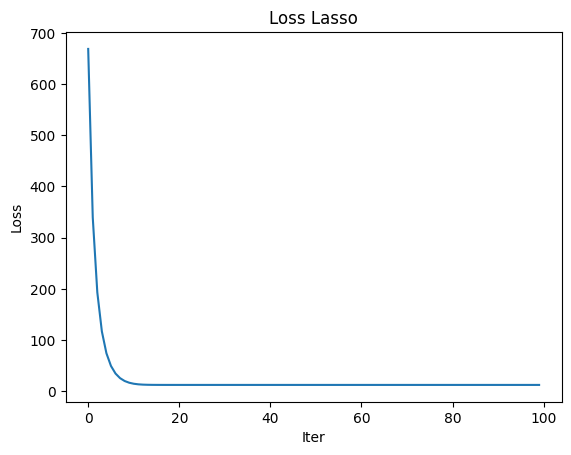

In [26]:
plt.plot(L)
plt.title('Loss Lasso')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

## Elastic Net

Elastic Net is a regularized regression method that combines the L1 and L2 penalties of the Lasso and Ridge methods, respectively. This combination allows it to harness the benefits of both techniques.
The loss function to minimize is defined as:

$$
L=\|y-Xw\|_{2}^{2}+\lambda_1\|w\|_{1} + \lambda_2 \|w\|_2
$$

Hence in this problem we have $2$ parameters to tune.

We can rewrite the problem as follows, so that we have only $1$ parameter $\lambda$ to tune (i.e. as a convex combination of Ridge and Lasso penalties):

$$
L=\|y-Xw\|_{2}^{2}+(\lambda_r) \cdot \lambda\|w\|_{1} + (1 - \lambda_r) \cdot \lambda \|w\|_2
$$

where $\lambda_r$, which is provided in input, is the _importance_ given to the $L1$ penalty (the opposite is also possible).

1. Since the derivative of the sum is the sum of the derivatives, put together all the elements seen so far and implement the GD algorithm for ElasticNet

In [16]:
# Elastic Net Loss Function
def ElasticNetSquareLoss(X, y, w, lr, l):
    """
    Calculate the Elastic Net loss for linear regression.

    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset.
    y : array of float of dim n
        Vector containing the ground truth value of each data point.
    w : array of float of dim d
        Weights of the fitted line.
    lr : float
        Convex combination parameter (controls L1 vs. L2 regularization).
    l : float
        Regularization strength parameter.

    Returns
    -------
    loss : float
        Elastic Net loss.
    """
    return SquareLoss(X, y, w) + lr * l * LA.norm(w, 1) + (1 - lr) * l * LA.norm(w, 2)

# Elastic Net Gradient Function
def ElasticNetGradient(X, y, w, lr, l, points):
    """
    Calculate the gradient for Elastic Net regularization.

    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset.
    y : array of float of dim n
        Vector containing the ground truth value of each data point.
    w : array of float of dim d
        Weights of the fitted line.
    lr : float
        Convex combination parameter (controls L1 vs. L2 regularization).
    l : float
        Regularization strength parameter.
    points : int
        Number of data points.

    Returns
    -------
    gradient : array of float of dim d
        Gradient of the Elastic Net regularization term.
    """
    return OLSGradient(X, y, w, points) + (1 - lr) * RidgeGradient(w, l) + lr * LassoGradient(w, l)

# Gradient Descent with Elastic Net Regularization
def GDElasticNet(X, y, lr, l, iter, gamma):
    """
    Perform Gradient Descent with Elastic Net regularization for linear regression.

    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset.
    y : array of float of dim n
        Vector containing the ground truth value of each data point.
    lr : float
        Convex combination parameter (controls L1 vs. L2 regularization).
    l : float
        Regularization strength parameter.
    iter : int
        Number of GD iterations.
    gamma : float
        Learning rate.

    Returns
    -------
    W : array of float of dim d x iter
        Weight vectors at each iteration.
    L : array of float of dim iter
        Loss values at each iteration.
    """
    points = X.shape[0]
    d = X.shape[1]
    W = np.zeros((d, iter))
    L = np.zeros(iter)
    w = np.random.normal(0, 0.1, d)
    for i in range(iter):
        W[:, i] = w
        w = w - gamma * ElasticNetGradient(X, y, w, lr, l, points)
        L[i] = ElasticNetSquareLoss(X, y, w, lr, l)
    return W, L


In [17]:
iter = 100
gamma = 0.001
lam = 0.1
lr = 0.5

wgdE, L = GDElasticNet(X, y, lr, lam, iter, gamma)
wpredE = wgdL[:,-1]

print('L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights: ', LA.norm(w-wpredE,2))

L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights:  0.006229601448557512


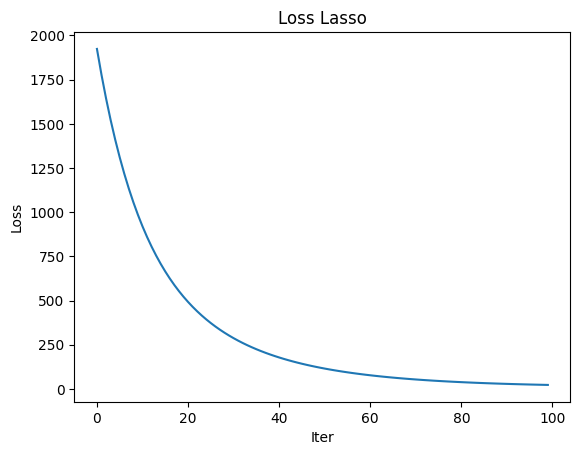

In [18]:
plt.plot(L)
plt.title('Loss Lasso')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

## $K$-fold Cross Validation

$K$-fold Cross Validation is a resampling technique used to estimate the performance and evaluate the robustness of a machine learning algorithm on unseen data. The parameter $K$ represents the number of non-overlapping subsets into which we partition our dataset. The general procedure involves the following steps:

1. **Shuffle the Dataset Randomly**: The dataset is randomly shuffled to ensure that it is not ordered in any specific way, preventing any inherent patterns from affecting the results.

2. **Split the Dataset into $K$ Groups**: The dataset is divided into $K$ groups, each containing approximately the same number of data points.

3. **Validation and Training**: For each of the $K$ groups, the following steps are performed:
   - Group $k$ is used as the validation set.
   - All the other $(K-1)$ groups are combined and used as the training set.
   - The machine learning model is trained on the training set and evaluated on the validation set.

4. **Summarize Results**: The results obtained from the $K$ validation runs are summarized, typically by calculating metrics like accuracy, mean squared error, or any relevant evaluation metric. Often, the mean of these metrics is taken as the final result.

**Remarks**:
- Each set of data is used once as the validation set and $K-1$ times as part of the training set.
- The choice of the hyperparameter $K$ involves a bias-variance trade-off. Lower values of $K$ may result in higher bias but lower variance, while higher values of $K$ may lead to lower bias but higher variance.
- Common choices for $K$ include $K=5$ or $K=10$.

In this context, $K$-fold Cross Validation is used to tune the hyperparameter $\lambda$ of the Ridge Regression algorithm, allowing for a comprehensive evaluation of its performance across different subsets of the dataset.

In [19]:
d = 1
w = np.random.normal(0, 1, d)
sigma = 3
points = 100
m = -10
M = 10
iter = 100
gamma = 0.001

Xtr, ytr = datagen(d, points, m, M, w, sigma) # training dataset
Xts, yts = datagen(d, points, m, M, w, sigma) # test dataset

In [20]:
def KFoldCVRLS(Xtr, ytr, K, lam):
    """
    Parameters
    ----------
    Xtr : matrix of float of dim n x d
        Dataset
    Ytr : array of float of dim n
        Ground truth values
    K : int
        Number of folds to split the data into
    lam : array of float
        Tuning hyperparameter under analysis
    """
    num_hpar = len(lam) # number of possible values for the hyperparameter
    points = Xtr.shape[0] # total training points
    fold_size = int(np.ceil(points/K)) # size of each K-fold
    # array containing the mean and std of the training error for each
    # hyperparameter accross all K runs of CV
    tr_mean = np.zeros(num_hpar)
    val_mean = np.zeros(num_hpar)
    # array containing the mean and std of the validation error for each
    # hyperparameter accross all K runs of CV
    tr_std = np.zeros(num_hpar)
    val_std = np.zeros(num_hpar)
    # random permutation of training data
    rand_idx = np.random.choice(points, size=points, replace=False)
    # train and validation loss for each of the K runs for each of the
    # possible hyperparameter values
    train_loss = np.zeros((num_hpar,K))
    val_loss = np.zeros((num_hpar,K))

    # loop across all hyperparameters values
    for l_idx, l in enumerate(lam):
        first = 0
        # K-fold CV runs
        for fold in range(K):
            # create a mask to distinguish train and validation set for this run
            flags = np.zeros(points)
            flags[first:first + fold_size] = 1;
            # construct the  training and validation set
            X = Xtr[rand_idx[flags==0]]
            y = ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            y_val = ytr[rand_idx[flags==1]]

            # compute the training error of the Ridge regression for the given value of lambda
            W, L = GDRidge(X, y, iter, gamma, points, d, l)
            train_loss[l_idx, fold] = L[-1]

            # compute the validation error of the regression for the given value of lambda
            val_error = SquareLoss(X_val, y_val, W[:, -1])
            val_loss[l_idx, fold] = val_error

            # update the first position to select the next fold
            first = first + fold_size

        # summarize performance metrics
        tr_mean[l_idx] = np.mean(train_loss[l_idx,:])
        val_mean[l_idx] = np.mean(val_loss[l_idx,:])

        tr_std[l_idx] = np.std(train_loss[l_idx,:])
        val_std[l_idx] = np.std(val_loss[l_idx,:])

    best_par_idx = np.argmin(val_mean)
    best_par = lam[best_par_idx]

    return best_par, val_mean, val_std, tr_mean, tr_std

In [21]:
K = 10
lam = np.linspace(0, 1, 11)
print('Lambda is chosen among: ', lam)

best_par, val_mean, val_std, tr_mean, tr_std = KFoldCVRLS(Xtr, ytr, K, lam)
print('Best lambda: ', best_par)

Lambda is chosen among:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Best lambda:  0.0


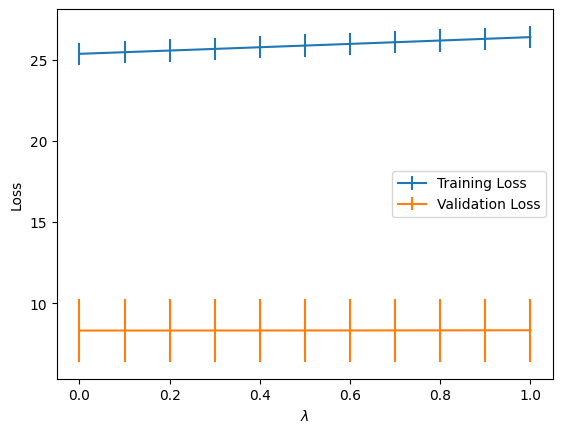

In [22]:
plt.errorbar(lam, tr_mean, yerr=tr_std, label= 'Training Loss')
plt.errorbar(lam, val_mean, yerr=val_std, label= 'Validation Loss')
plt.xlabel(r'$\lambda$')
plt.ylabel('Loss')
plt.legend()
plt.show();

**Additional Resources**



*   [Regularization Part 1: Ridge (L2) Regression](https://youtu.be/Q81RR3yKn30?si=8zRBumzaZ_zLO2Z5)
*   [Regularization Part 2: Lasso (L1) Regression](https://youtu.be/NGf0voTMlcs?si=dYklAVtMtZKU2Vao)
* [Ridge vs Lasso Regression, Visualized](https://www.youtube.com/watch?v=Xm2C_gTAl8c)

